In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import interp1d
import math
from math import pi
import matplotlib.dates as mdates
import datetime
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import coolwarm

def individual_bases(K1,K2,T_start,T,P1,P2):
    w1 = 2*pi/P1
    w2 = 2*pi/P2
    Base=np.zeros((T,(2*K1)+(2*K2)+1))
    c=0
    for t in range(T_start,T_start+T):
        Basis=[1]
        for i in range(1,K1+1):
            Basis.append(math.cos(i*w1*t))
            Basis.append(math.sin(i*w1*t))
        for i in range(1,K2+1):
            Basis.append(math.cos(i*w2*t))
            Basis.append(math.sin(i*w2*t))
        Base[c,:]=Basis
        c+=1
    B_P0 = Base[:,0].reshape(-1,1)
    B_P1 = Base[:,1:(2*K1)+1]
    B_P2 = Base[:,(2*K1)+1:(2*K2)+(2*K1+1)]
    Bases = [B_P0,B_P1,B_P2]
    return Bases

def basis_with_additive_terms(K1,K2,T_start,T,P1,P2):
    Bases = individual_bases(K1,K2,T_start,T,P1,P2)
    B_P0 = Bases[0]
    B_P1 = Bases[1]
    B_P2 = Bases[2]
    B = np.hstack([B_P0,B_P1,B_P2])
    return B

def sunrise_sunset_problem(K, P, T_start, T, z1):
    Ba = basis_with_additive_terms(K[0],K[1],T_start,T,P[0],P[1])
    Thetaa = cp.Variable(Ba.shape[1])
    BTa = Ba @ Thetaa
    obj = -cp.sum(cp.multiply(z1, BTa) - cp.logistic(BTa))
    prob = cp.Problem(cp.Minimize(obj))
    return prob,Ba

def sunrise_sunset(morningc,kappa):
    sunrise_indices = []
    sunset_indices = []
    for j in range(1, len(morningc)):
        if morningc[j-1] < kappa < morningc[j]:
            exact_crossing = j - 1 + (kappa - morningc[j-1]) / (morningc[j] - morningc[j-1])
            sunrise_indices.append(exact_crossing)
        elif morningc[j-1] > kappa > morningc[j]:
            exact_crossing = j - 1 + (kappa - morningc[j-1]) / (morningc[j] - morningc[j-1])
            sunset_indices.append(exact_crossing)
    return sunrise_indices,sunset_indices

def index_to_time(index):
    time = (index*15)%(96*15)/60
    return time # Return as decimal time

def decimal_to_hms(decimal_time):
    hours = int(decimal_time)
    minutes = int((decimal_time - hours) * 60)
    seconds = int(((decimal_time - hours) * 60 - minutes) * 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

def upsample_day_with_averaging(y1, sunrise, sunset):
    local_indices = np.linspace(sunrise, sunset, num=100)
    upsampled_segment = np.zeros(100)
    for i, idx in enumerate(local_indices):
        lower_index = int(np.floor(idx))
        upper_index = int(np.ceil(idx))
        if lower_index == upper_index:
            upsampled_segment[i] = y1[lower_index]
        else:
            weight_upper = idx - lower_index
            weight_lower = upper_index - idx
            upsampled_segment[i] = (weight_lower * y1[lower_index] + weight_upper * y1[upper_index]) / (weight_lower + weight_upper)
    return upsampled_segment

def downsample_data(upsampled_data, sunrise_indices, sunset_indices, original_length):
    num_days = len(sunrise_indices)
    y1 = np.zeros(original_length)
    count = np.zeros(original_length)
    for day in range(num_days):
        sunrise = sunrise_indices[day]
        sunset = sunset_indices[day]
        start_index = int(np.floor(sunrise))
        end_index = int(np.ceil(sunset)) + 1
        local_indices = np.linspace(sunrise, sunset, num=100)
        for i, idx in enumerate(local_indices):
            lower_index = int(np.floor(idx))
            upper_index = int(np.ceil(idx))
            if lower_index == upper_index:
                y1[lower_index] += upsampled_data[day, i]
                count[lower_index] += 1
            else:
                weight_upper = idx - lower_index
                weight_lower = upper_index - idx
                y1[lower_index] += upsampled_data[day, i] * weight_lower
                y1[upper_index] += upsampled_data[day, i] * weight_upper
                count[lower_index] += weight_lower
                count[upper_index] += weight_upper
    non_zero_mask = count > 0
    y1[non_zero_mask] /= count[non_zero_mask]
    return y1




P = [365.24225*24*4,24*4]
K = [2,2]

kappa = 0.25

start_train = '2015-07-01 00:00:00'
end_train = '2017-06-30 23:45:00'

df = pd.read_csv("TADBC1078041-full.csv")
df['ts'] = pd.to_datetime(df['ts'])
df['ts'] = df['ts'] - pd.to_timedelta(8, unit='h')
df = df.set_index('ts')
df = df[['meas_val_f']].rename(columns={'meas_val_f': 'y'})
df['y'] = df['y'].clip(lower=0)
df_resampled = df.resample('15T').sum()
df_train = df_resampled.loc[start_train:end_train]
y1 = df_train['y'].to_numpy()

eps = 0.005* np.max(y1)
z1 = np.where(y1 >= eps, 1, 0)
T_start = 0
T = len(z1)

proba, Ba = sunrise_sunset_problem(K, P, T_start, T, z1)
proba.solve(verbose=False,solver=cp.MOSEK)
BTa=Ba@proba.variables()[0].value
morning_likelihood = np.exp(BTa) / (1 + np.exp(BTa))
sunrise_indices,sunset_indices = sunrise_sunset(morning_likelihood,kappa)
upsampled_data = np.zeros((731, 100))
for j in range(731):
    upsampled_data[j, :] = upsample_day_with_averaging(y1, sunrise_indices[j], sunset_indices[j])


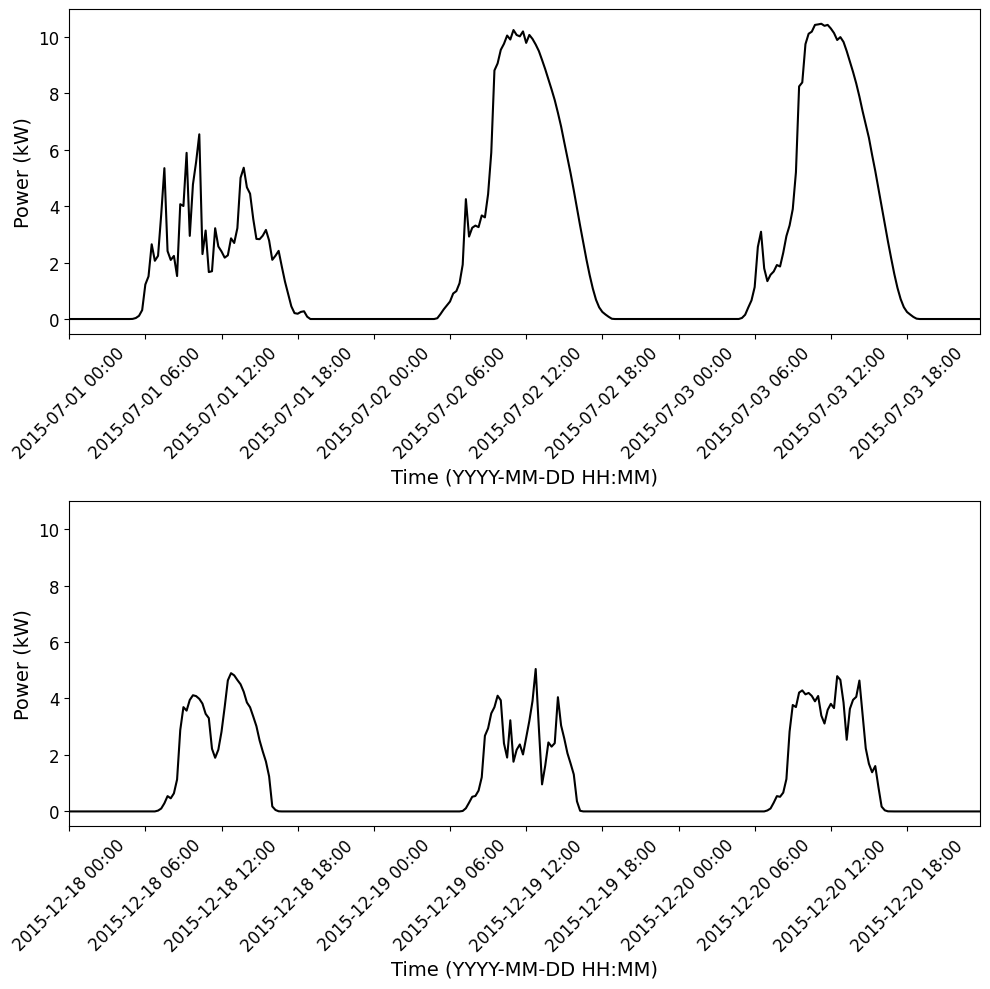

In [2]:
timestamps = pd.date_range(start=start_train, end=end_train, freq='15T')
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
axs = axs.flatten()
date_ranges = [("2015-07-01 00:00", "2015-07-03 23:45"), 
               ("2015-12-18 00:00", "2015-12-20 23:45")]
for i, date_range in enumerate(date_ranges):
    start, end = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
    mask = (timestamps >= start) & (timestamps <= end)
    axs[i].plot(timestamps[mask], y1[mask], color='black')
    axs[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[i].tick_params(axis='x', rotation=45, labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_ylabel('Power (kW)', fontsize=14)
    axs[i].set_xlabel('Time (YYYY-MM-DD HH:MM)', fontsize=14)
    axs[i].set_xlim(start, end)
plt.tight_layout()
plt.savefig("data.pdf")
plt.show()

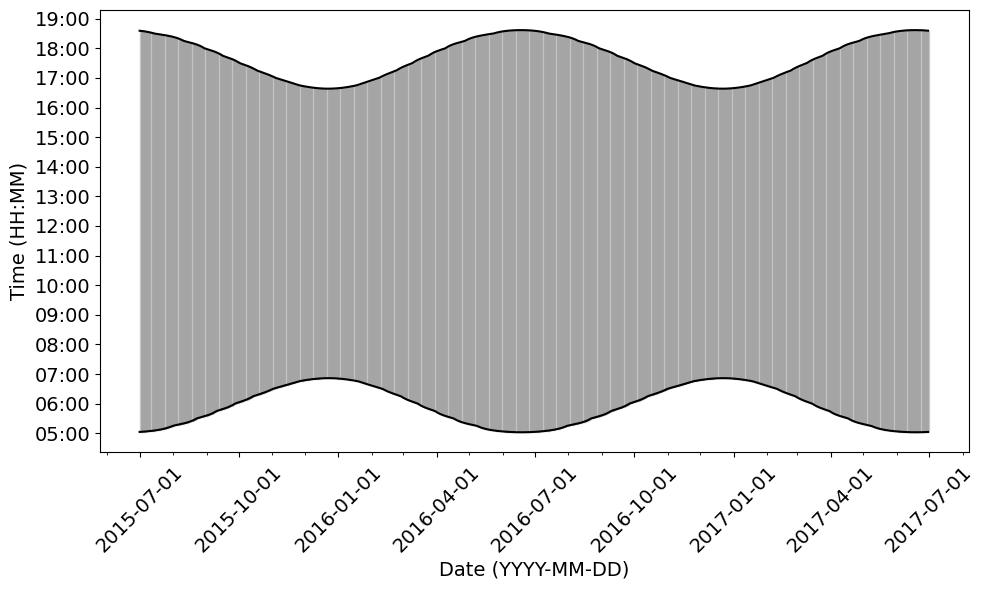

In [3]:
y1_dilated = upsampled_data
sunrise_decimal_times = [index_to_time(index) for index in sunrise_indices]
sunset_decimal_times = [index_to_time(index) for index in sunset_indices]
sunrise_times_hms = [decimal_to_hms(time) for time in sunrise_decimal_times]
sunset_times_hms = [decimal_to_hms(time) for time in sunset_decimal_times]
start_train = '2015-07-01'
end_train = '2017-06-30'
dates = pd.date_range(start=start_train, end=end_train, freq='D')
sunrise_times = [pd.to_datetime(time).time() for time in sunrise_times_hms]
sunset_times = [pd.to_datetime(time).time() for time in sunset_times_hms]
fig, ax = plt.subplots(figsize=(10, 6))
sunrise_times_plt = mdates.date2num([datetime.datetime.combine(datetime.date(1,1,1), t) for t in sunrise_times])
sunset_times_plt = mdates.date2num([datetime.datetime.combine(datetime.date(1,1,1), t) for t in sunset_times])
ax.plot(dates, sunrise_times_plt, color='black')
ax.plot(dates, sunset_times_plt, color='black')
for date, sunrise_time, sunset_time in zip(dates, sunrise_times_plt, sunset_times_plt):
    ax.fill_betweenx([sunrise_time, sunset_time], date, date + pd.Timedelta(days=1), color='grey', alpha=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10), bymonthday=1))  # Ticks every 3 months starting from January 1st
ax.xaxis.set_minor_locator(mdates.MonthLocator())  # Minor ticks every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.yaxis_date()
ax.yaxis.set_major_locator(mdates.HourLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(axis='x', rotation=45, labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('Date (YYYY-MM-DD)',fontsize=14)
ax.set_ylabel('Time (HH:MM)',fontsize=14)
plt.tight_layout()
plt.savefig("sunrise_sunset.pdf")
plt.show()

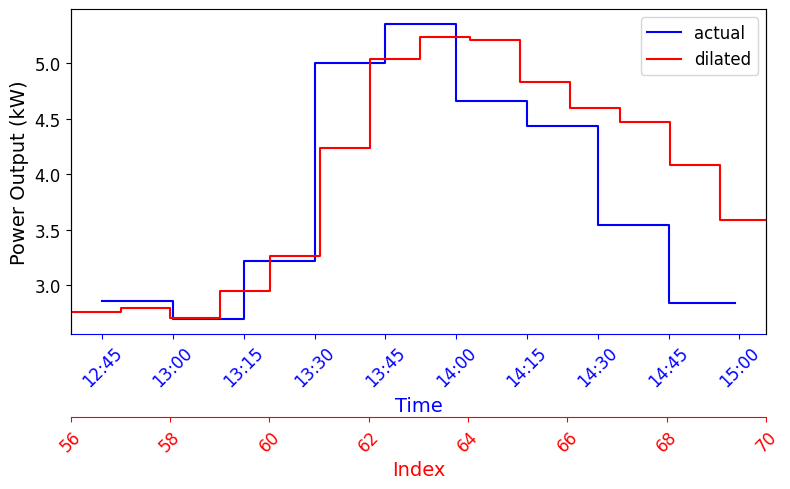

In [4]:
day_index = 0
sunrise = int(sunrise_indices[day_index])
sunset = int(sunset_indices[day_index])
start_time = pd.Timestamp('2015-07-01') + pd.Timedelta(minutes=15 * sunrise)
times = pd.date_range(start=start_time, periods=(sunset - sunrise + 1), freq='15T')
start_interval = pd.Timestamp('2015-07-01 12:45')
end_interval = pd.Timestamp('2015-07-01 14:45')
mask = (times >= start_interval) & (times <= end_interval)
filtered_times = times[mask]
start_index = sunrise + np.where(mask)[0][0]
end_index = sunrise + np.where(mask)[0][-1] + 1
filtered_snippet = y1[start_index:end_index]
# Create a new time index for the step function with 1-minute intervals
step_times = pd.date_range(start=filtered_times[0], end=filtered_times[-1] + pd.Timedelta(minutes=14), freq='T')
step_values = np.repeat(filtered_snippet, 15)
# Define the indices for the interval for upsampled data
start_index_upsampled = 56
end_index_upsampled = 69
# Extract the upsampled data for the specified interval
upsampled_snippet = upsampled_data[day_index][start_index_upsampled:end_index_upsampled + 1]
upsampled_step_values = np.repeat(upsampled_snippet, 15)
upsampled_step_times = np.linspace(start_index_upsampled, end_index_upsampled + 1, len(upsampled_step_values))
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.step(step_times, step_values, where='post', label='actual', color='blue')
ax1.set_ylabel('Power Output (kW)', fontsize=14)
ax1.tick_params(axis='x', rotation=45, colors='blue', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.spines['bottom'].set_color('blue')
ax1.set_xlabel('Time', color='blue', fontsize=14)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_tick_params(labelsize=12)
ax2 = ax1.twiny()
ax2.spines['top'].set_position(('outward', 40))
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.tick_params(axis='x', rotation=45, colors='red', labelsize=12)
ax2.spines['bottom'].set_color('red')
ax2.step(upsampled_step_times, upsampled_step_values, where='post', label='dilated', color='red')
ax2.set_xlim(start_index_upsampled, end_index_upsampled + 1)
ax2.set_xlabel('Index', color='red', fontsize=14)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig("time_dilate.pdf")
plt.show()

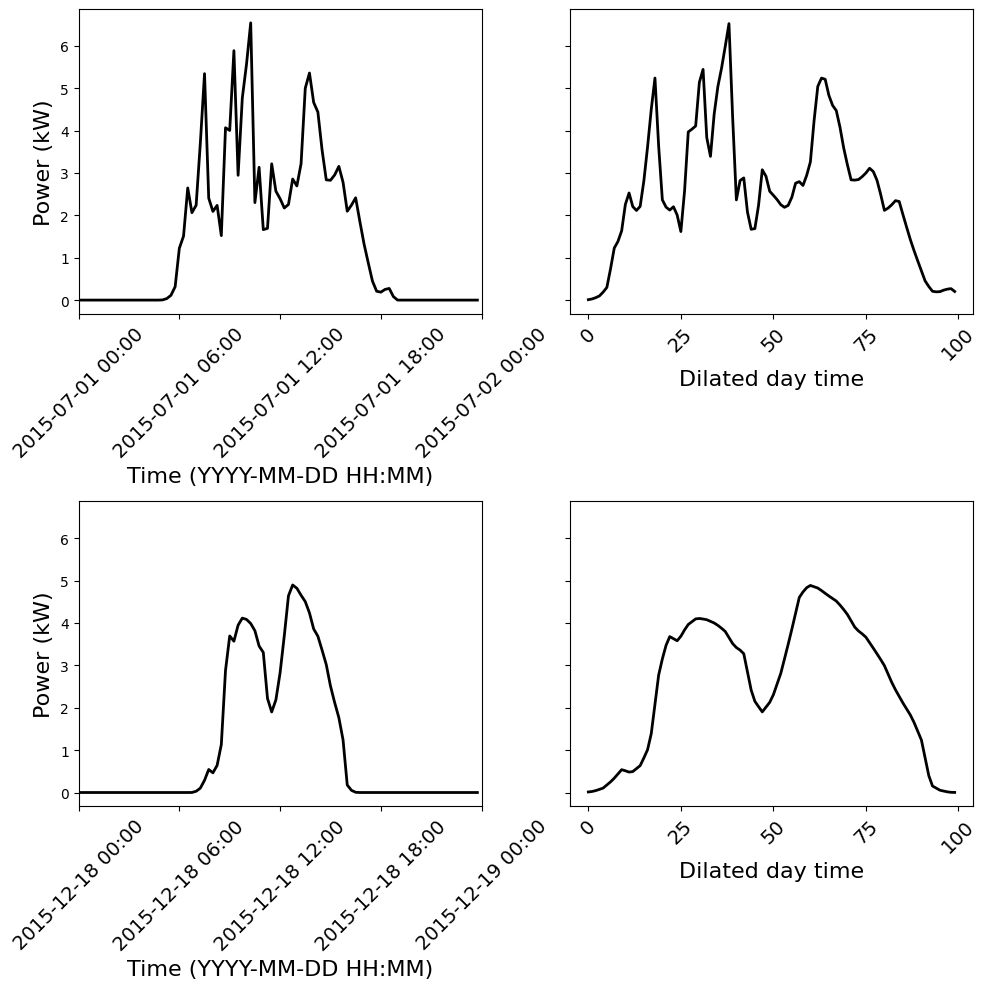

In [5]:
start_train = '2015-07-01 00:00:00'
end_train = '2017-06-30 23:45:00'
timestamps = pd.date_range(start=start_train, end=end_train, freq='15T')
selected_dates = ['2015-07-01', '2015-12-18']
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
for i, selected_date in enumerate(selected_dates):
    dilated_index = (pd.to_datetime(selected_date) - pd.to_datetime(start_train)).days
    mask = (timestamps >= selected_date) & (timestamps < pd.to_datetime(selected_date) + pd.Timedelta(days=1))
    axs[i, 0].plot(timestamps[mask], y1[mask], color='black', label='actual', linewidth=2)
    axs[i, 1].plot(np.arange(100), upsampled_data[dilated_index], color='black', label='dilated', linewidth=2)
    axs[i, 0].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[i, 0].tick_params(axis='x', rotation=45, labelsize=14)
    axs[i, 0].set_ylabel('Power (kW)', fontsize=16)
    axs[i, 0].set_xlabel('Time (YYYY-MM-DD HH:MM)', fontsize=16)
    axs[i, 0].set_xlim(pd.to_datetime(selected_date), pd.to_datetime(selected_date) + pd.Timedelta(days=1))
    axs[i, 1].set_xticks(np.linspace(0, 100, 5))  # 25 indices interval
    axs[i, 1].tick_params(axis='x', rotation=45, labelsize=14)
    axs[i, 1].set_xlabel('Dilated day time', fontsize=16)

plt.tight_layout()
plt.savefig("time_dilation.pdf")
plt.show()

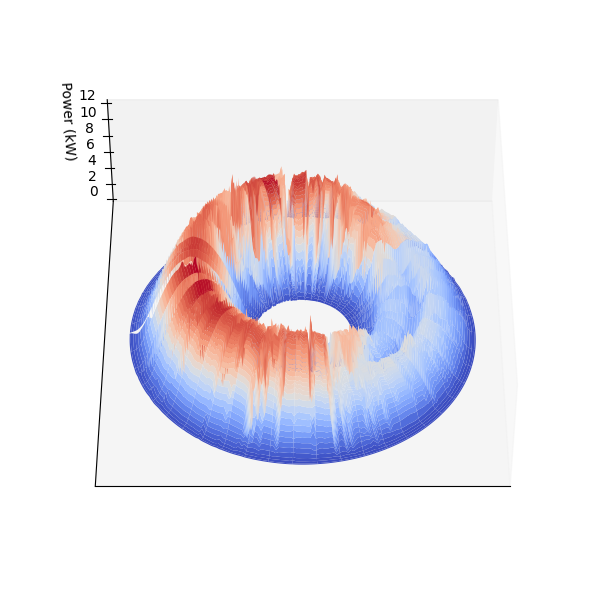

In [6]:
def plot_Bundt_cake(data, inner_radius=1, slice_thickness=100, figsize=(12, 8), elev=45, azim=30, zoom=1.0, xlabel='', ylabel='', zlabel='Power (kW)', cmap='coolwarm'):
    num_days, slices_per_day = data.shape
    theta_days = np.linspace(0, 2 * np.pi, num_days, endpoint=False)
    theta_slices = np.linspace(0, 2 * np.pi, slices_per_day, endpoint=False)
    theta_grid, slice_grid = np.meshgrid(theta_days, theta_slices)
    x = (inner_radius + slice_grid * (slice_thickness / slices_per_day)) * np.cos(theta_grid)
    y = (inner_radius + slice_grid * (slice_thickness / slices_per_day)) * np.sin(theta_grid)
    z = data.T
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap=cmap, edgecolor='none')
    ax.grid(False)
    ax.set_facecolor("white")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.view_init(elev=elev, azim=azim)  
    ax.set_box_aspect([zoom, zoom, 1])
    plt.tight_layout()
    plt.savefig("cake.pdf")
    plt.show()
data = upsampled_data[:365]
plot_Bundt_cake(data, inner_radius=1.5, slice_thickness=60, figsize=(6, 6), elev=45, azim=90, zoom=2.8, xlabel='', ylabel='', zlabel='Power (kW)', cmap='coolwarm')

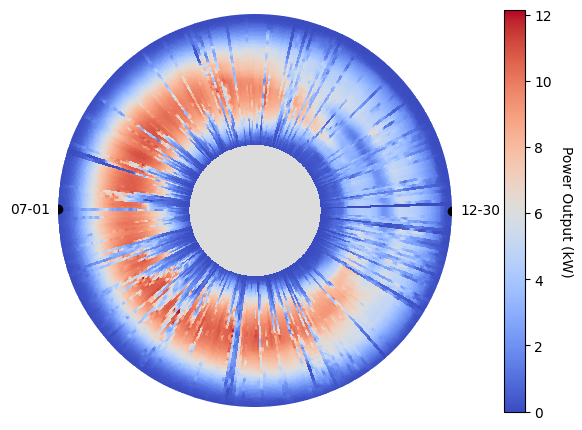

In [7]:
extended_data = np.zeros((365, 150))
whiter_value = (data.min() + data.max()) / 2
extended_data[:, :50] = whiter_value
extended_data[:, 50:] = data
inner_radius = 0.3 
outer_radius = 1.0
fig, ax = plt.subplots(figsize=(6, 7), subplot_kw={'projection': 'polar'})
num_days, num_entries = extended_data.shape
theta = np.linspace(0, 2 * np.pi, num_days + 1)
radii = np.linspace(inner_radius, outer_radius, num_entries + 1)
norm = plt.Normalize(extended_data.min(), extended_data.max())
cmap = plt.cm.coolwarm
for i in range(num_days):
    theta1 = np.linspace(theta[i], theta[i + 1], 2)
    theta_grid, radii_grid = np.meshgrid(theta1, radii)
    z = extended_data[i].reshape((num_entries, 1))
    ax.pcolormesh(theta_grid, radii_grid, z, cmap=cmap, norm=norm, shading='flat')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2 + np.pi / 2)
ax.spines['polar'].set_visible(False)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
date_labels = pd.date_range(start='2015-07-01', periods=365, freq='D')
specific_dates = ['07-01', '12-30']
specific_indices = [0, 182]  # Assuming 07-01 is the first day and 12-30 is the 183rd day
for idx in specific_indices:
    date_str = date_labels[idx].strftime('%m-%d')
    angle = theta[idx] + (theta[1] - theta[0]) / 2 
    ax.text(angle, outer_radius + 0.1, date_str, ha='center', va='center', color='black', fontsize=10, rotation=0)
    ax.plot(angle, outer_radius, 'ko')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Power Output (kW)', rotation=270, labelpad=15)
plt.tight_layout()
plt.savefig("toast.pdf")
plt.show()

In [8]:
def individual_bases_bundt(K1,K2,T_start,T,P1,P2):
    w1 = 2*pi/P1
    w2 = pi/P2
    Base=np.zeros((T,(2*K1)+(K2)+1))
    c=0
    for t in range(T_start,T_start+T):
        Basis=[1]
        for i in range(1,K1+1):
            t_using = t % P1
            Basis.append(math.cos(i*w1*t_using))
            Basis.append(math.sin(i*w1*t_using))
        for i in range(1,K2+1):
            t_using = t % P2
            Basis.append(math.sin(i*w2*t_using))
        Base[c,:]=Basis
        c+=1
    B_P0 = Base[:,0].reshape(-1,1)
    B_P1 = Base[:,1:(2*K1)+1]
    B_P2 = Base[:,(2*K1)+1:(K2)+(2*K1+1)]
    Bases = [B_P0,B_P1,B_P2]
    return Bases

def cross_bases(B_P1, B_P2):
    outer_products = [np.outer(B_P1[i], B_P2[i]).flatten().reshape(-1,1) for i in range(B_P1.shape[0])]
    result = np.concatenate(outer_products, axis=1).T
    return result

def basis_with_cross_terms_bundt(K1,K2,T_start,T,P1,P2):
    Bases = individual_bases_bundt(K1,K2,T_start,T,P1,P2)
    B_P0 = Bases[0]
    B_P1 = Bases[1]
    B_P2 = Bases[2]
    C_12 = cross_bases(B_P1,B_P2)
    B = np.hstack([B_P0,B_P1,B_P2,C_12])
    return B

def create_regularization_time_bundt(K,theta):
    lambdas_time = cp.Parameter(2,nonneg=True)
    period1 = np.tile(np.repeat(np.arange(1, K[0] + 1), 2), 1)#*lambdas[0]
    period2 = np.tile(np.repeat(np.arange(1, K[1] + 1), 1), 1)#*lambdas[1]
    period12 = np.tile(np.repeat(np.arange(1, K[1] + 1), 1), 2*K[0])#*lambdas[1]
    r_period1= lambdas_time[0]*cp.sum_squares(np.diag(period1)@theta[1:(1+len(period1))])
    r_period2= lambdas_time[1]*cp.sum_squares(np.diag(period2)@theta[(1+len(period1)):(1+len(period1)+len(period2))])
    r_period12= lambdas_time[1]*cp.sum_squares(np.diag(period12)@theta[(1+len(period1)+len(period2)):(1+len(period1)+len(period2)+len(period12))])
    regularization_time = r_period1 + r_period2 + r_period12
    return regularization_time

def reshape_column(B_bundt, j, D, M):
    column_data = B_bundt[:, j]
    if len(column_data) != D * M:
        raise ValueError(f"The selected column has {len(column_data)} elements, which cannot be reshaped into a ({D}, {M}) matrix.")
    return column_data.reshape((D, M))

def pinball_slopes(percentiles):
    percentiles=np.asarray(percentiles)
    a=(percentiles-50)*(0.01)
    b=(0.5)*np.ones((len(a),))
    return a,b

y1_flattened = upsampled_data.flatten()
percentiles = [2,10,20,30,40,50,60,70,80,90,98]
K = [3, 10]
P = [365.24225*100,100]
T_start = 0
T = len(y1_flattened)
D = 731
M = 100

B_bundt = basis_with_cross_terms_bundt(K[0], K[1], T_start, T, P[0], P[1])
a, b = pinball_slopes(percentiles)
num_quantiles = len(a)
Theta = cp.Variable((B_bundt.shape[1], num_quantiles))
BT_bundt = B_bundt @ Theta
y1_reshaped = y1_flattened.reshape(-1, 1)
non_nan_mask = ~np.isnan(y1_reshaped)
Var = cp.multiply(non_nan_mask, y1_reshaped - BT_bundt)
obj = cp.sum(Var @ np.diag(a) + cp.abs(Var) @ np.diag(b))
cons = [cp.diff(BT_bundt, axis=1) >= 0.0001, BT_bundt[:, 0] >= 0.0]
prob = cp.Problem(cp.Minimize(obj), cons)
prob.solve(verbose=False, solver=cp.MOSEK)
Q=B_bundt@Theta.value
Q2, Q10, Q20, Q30, Q40, Q50, Q60, Q70, Q80, Q90, Q98 = [Q[:, i].reshape(len(Q)//100, 100) for i in range(11)]
quantiles = np.array([Q[:, i].reshape(len(Q)//100, 100) for i in range(11)])  # Q2, Q10, ..., Q98

original_length = len(y1)  # This should match the length of your original y1 array
downsampled_signal = downsample_data(upsampled_data, sunrise_indices, sunset_indices, original_length)
y1_undilated = downsampled_signal
Q2_undilated = downsample_data(Q2, sunrise_indices, sunset_indices, original_length)
Q10_undilated = downsample_data(Q10, sunrise_indices, sunset_indices, original_length)
Q20_undilated = downsample_data(Q20, sunrise_indices, sunset_indices, original_length)
Q30_undilated = downsample_data(Q30, sunrise_indices, sunset_indices, original_length)
Q40_undilated = downsample_data(Q40, sunrise_indices, sunset_indices, original_length)
Q50_undilated = downsample_data(Q50, sunrise_indices, sunset_indices, original_length)
Q60_undilated = downsample_data(Q60, sunrise_indices, sunset_indices, original_length)
Q70_undilated = downsample_data(Q70, sunrise_indices, sunset_indices, original_length)
Q80_undilated = downsample_data(Q80, sunrise_indices, sunset_indices, original_length)
Q90_undilated = downsample_data(Q90, sunrise_indices, sunset_indices, original_length)
Q98_undilated = downsample_data(Q98, sunrise_indices, sunset_indices, original_length)

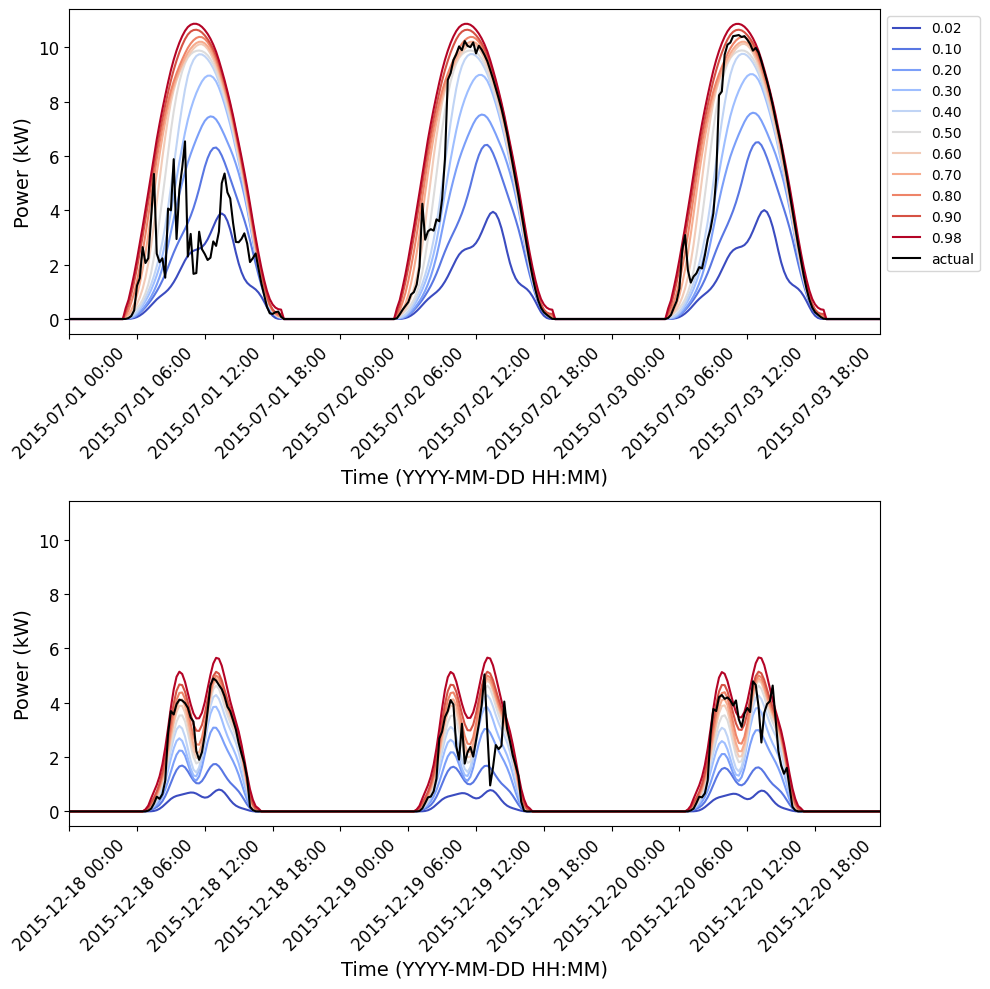

In [9]:
start_train = '2015-07-01 00:00:00'
end_train = '2017-06-30 23:45:00'
timestamps = pd.date_range(start=start_train, end=end_train, freq='15T')
quantile_labels = ["2", "10", "20", "30", "40", "50", "60", "70", "80", "90", "98"]
colors = [coolwarm(i) for i in np.linspace(0, 1, len(quantile_labels))]
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
axs = axs.flatten()
date_ranges = [("2015-07-01 00:00", "2015-07-03 23:45"), 
               ("2015-12-18 00:00", "2015-12-20 23:45")]

for i, date_range in enumerate(date_ranges):
    start, end = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
    mask = (timestamps >= start) & (timestamps <= end)
    for j, q_label in enumerate(quantile_labels):
        quantile_var_name = f"Q{q_label}_undilated"
        if quantile_var_name in globals():
            quantile_data = globals()[quantile_var_name]
            axs[i].plot(timestamps[mask], quantile_data[mask], color=colors[j], label=f"0.{q_label}" if q_label != "2" else "0.02")

    axs[i].plot(timestamps[mask], y1[mask], color='black', label='actual')
    
    axs[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[i].tick_params(axis='x', rotation=45, labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_ylabel('Power (kW)', fontsize=14)
    axs[i].set_xlabel('Time (YYYY-MM-DD HH:MM)', fontsize=14)
    axs[i].set_xlim(start, end)
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("quantiles_mapped_back.pdf")
plt.show()

In [11]:
def hinge0(Q_ij, Q_critical, Tau=1):
    if Q_ij <= Q_critical*0.7:
        return 0
    else:
        return 1

def hinge1(Q_ij, Q_critical, Tau=1):
    if Q_ij >= Q_critical*0.7:
        return 0
    else:
        return 1
    
def compute_hinge_losses(Q, Q_critical, Tau):
    T = Q.shape[1]
    L = np.zeros_like(Q)
    for j in range(T):
        L[0, j] = hinge0(Q[0, j], Q_critical[j], Tau)
        L[1, j] = hinge1(Q[1, j], Q_critical[j], Tau)
    return L

def find_optimal_path(L, lam):
    T = L.shape[1]
    cum_loss = L.copy()
    for t in range(1, T):
        for i in range(2):
            cum_loss[i, t] += min(cum_loss[1-i, t-1] + lam, cum_loss[i, t-1])
    Z = np.zeros(T, dtype=int)
    Z[T-1] = np.argmin(cum_loss[:, T-1])
    for t in range(T-2, -1, -1):
        prev_row = Z[t+1]
        if cum_loss[prev_row, t] <= cum_loss[1-prev_row, t] + lam:
            Z[t] = prev_row
        else:
            Z[t] = 1 - prev_row

    return Z


T = 100  # Number of nodes in width
Q_critical = Q98  # Critical quantile value
Tau = 1     # Standard slope for hinge loss
lam = 2     # Friction loss factor

filtered_clearsky = np.zeros((upsampled_data.shape[0],upsampled_data.shape[1])) #(731,100)
for i in range(len(upsampled_data)):
    day_index = i
    data_day = upsampled_data[day_index]
    actual_values_day = upsampled_data[day_index]
    Q = np.vstack([actual_values_day, actual_values_day])  # Assign to both rows
    Q_critical_day = Q_critical[day_index]
    L = compute_hinge_losses(Q, Q_critical_day, Tau)
    Z = find_optimal_path(L, lam)
    filtered_clearsky[i] = Z
filtered_clearsky[:, :10] = 0
filtered_clearsky[:, -10:] = 0
downsampled_filtered_clearsky = downsample_data(filtered_clearsky, sunrise_indices, sunset_indices, original_length)

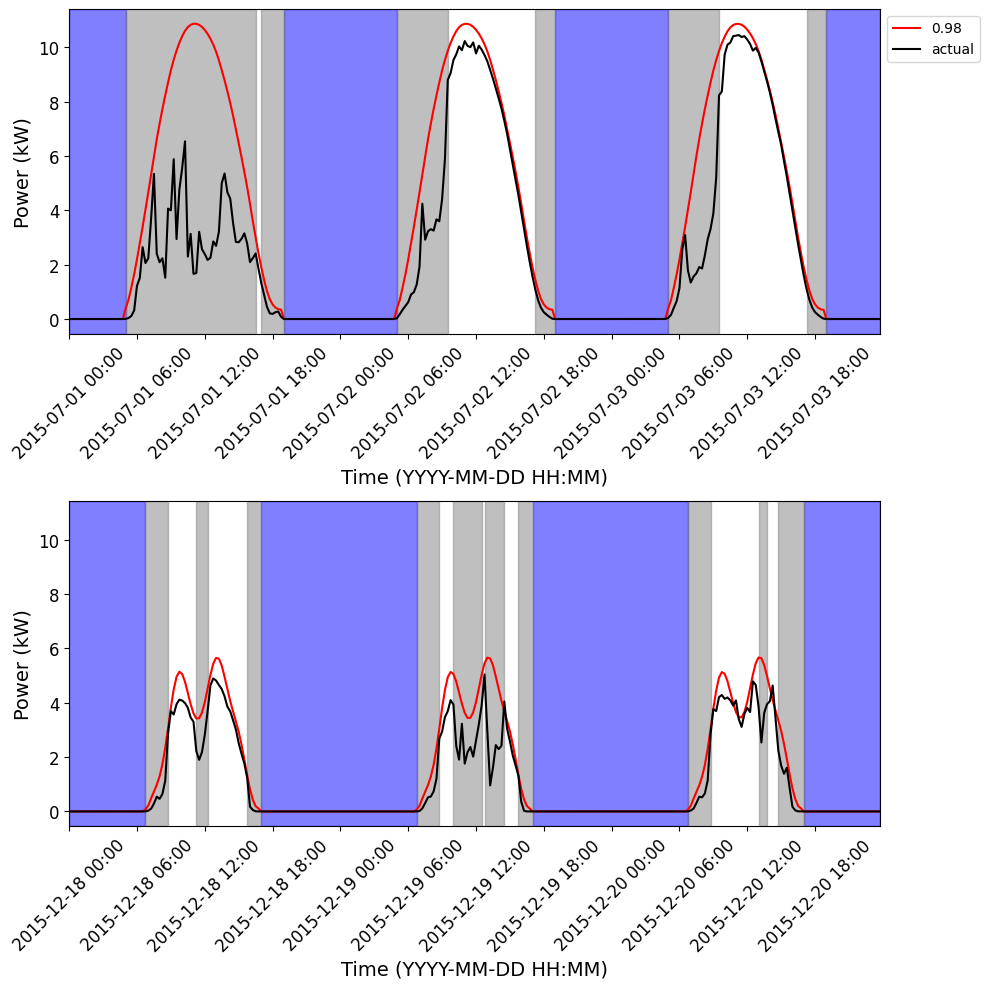

In [12]:
y1_daytime = np.zeros_like(y1, dtype=bool)
for j in range(len(sunrise_indices)):
    sunrise = sunrise_indices[j]
    sunset = sunset_indices[j]
    start_index = int(np.floor(sunrise))
    end_index = int(np.ceil(sunset)) + 1
    y1_daytime[start_index:end_index] = 1
    
start_train = '2015-07-01 00:00:00'
end_train = '2017-06-30 23:45:00'
timestamps = pd.date_range(start=start_train, end=end_train, freq='15T')
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
date_ranges = [("2015-07-01 00:00", "2015-07-03 23:45"), 
               ("2015-12-18 00:00", "2015-12-20 23:45")]

for i, date_range in enumerate(date_ranges):
    start, end = pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1])
    mask = (timestamps >= start) & (timestamps <= end)
    axs[i].plot(timestamps[mask], Q98_undilated[mask], color='red', label='0.98')
    axs[i].plot(timestamps[mask], y1[mask], color='black', label='actual')
    blue_mask = ~y1_daytime[mask]  # Nighttime is when y1_daytime is False
    gray_mask = y1_daytime[mask] & (downsampled_filtered_clearsky[mask] < 0.8)  # Non-clear sky during daytime
    blue_change_points = np.where(np.diff(blue_mask.astype(int)))[0] + 1
    blue_change_points = np.insert(blue_change_points, 0, 0)
    blue_change_points = np.append(blue_change_points, len(blue_mask))
    for j in range(len(blue_change_points) - 1):
        if blue_mask[blue_change_points[j]]:
            start_idx = blue_change_points[j]
            end_idx = min(blue_change_points[j + 1], len(timestamps[mask]) - 1)
            axs[i].axvspan(timestamps[mask][start_idx], timestamps[mask][end_idx], color='blue', alpha=0.5)
    gray_change_points = np.where(np.diff(gray_mask.astype(int)))[0] + 1
    gray_change_points = np.insert(gray_change_points, 0, 0)
    gray_change_points = np.append(gray_change_points, len(gray_mask))
    for j in range(len(gray_change_points) - 1):
        if gray_mask[gray_change_points[j]]:
            start_idx = gray_change_points[j]
            end_idx = min(gray_change_points[j + 1], len(timestamps[mask]) - 1)
            axs[i].axvspan(timestamps[mask][start_idx], timestamps[mask][end_idx], color='gray', alpha=0.5)
    axs[i].set_xlim(start, end)
    axs[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axs[i].tick_params(axis='x', rotation=45, labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_ylabel('Power (kW)', fontsize=14)
    axs[i].set_xlabel('Time (YYYY-MM-DD HH:MM)', fontsize=14)
axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("clear_sky.pdf")
plt.show()